In [208]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import numpy as np
import spacy
import en_core_web_sm
import tomotopy as tp
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('subject')
stop_words.add('http')
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
nlp = en_core_web_sm.load()

In [209]:
class LoadData:
    def __init__(self, ds_name):
        self.ds_name = ds_name
    def get_embeddings(self):
        if self.ds_name == "20NEWS":
            print("Dataset 20NEWS loaded...")
            x = np.load("representations.npy").astype('float32')
            x = x / tf.expand_dims(tf.norm(x, ord=2, axis=-1), -1).numpy()
        elif self.ds_name == "BBC":
            x = np.load("representations_bbc.npy").astype('float32')
            x = x / tf.expand_dims(tf.norm(x, ord=2, axis=-1), -1).numpy()
        elif self.ds_name =="Kpris":
            x = np.load("representations_kpris.npy").astype('float32')
            x = x / tf.expand_dims(tf.norm(x, ord=2, axis=-1), -1).numpy()
        return x

In [210]:
class Cluster:
    def __init__(self, ds_name, epochs, pretrain_batch_size, batch_size, input_shape, hidden_units):
        self.ds_name = ds_name
        self.epochs = epochs
        self.pretrain_batch_size = pretrain_batch_size
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.hidden_units = hidden_units
        
    def model_base(self, load_weights=True):
        input_shape = self.input_shape
        init = 'uniform'
        activation = 'relu'
        input = layers.Input(shape=input_shape)
        x = layers.Dense(500, activation=activation, kernel_initializer=init)(input)
        x = layers.Dense(500, activation=activation, kernel_initializer=init)(x)
        x = layers.Dense(2000, activation=activation, kernel_initializer=init)(x)
        x = layers.Dense(self.hidden_units, activation=activation, kernel_initializer=init)(x)
        h = x
        x = layers.Dense(2000, activation=activation, kernel_initializer=init)(x)
        x = layers.Dense(500, activation=activation, kernel_initializer=init)(x)
        x = layers.Dense(500, activation=activation, kernel_initializer=init)(x)
        y = layers.Dense(input_shape, activation=activation, kernel_initializer=init)(x)
        output = layers.Concatenate()([h, y])
        model = Model(inputs=input, outputs=output)
        if load_weights:
            model.load_weights(f'weight_base_{self.ds_name}.h5')
        print('model_conv: weights was loaded')
        return model
    
    def loss_train_base(self, y_true, y_pred):
        y_true = layers.Flatten()(y_true)
        y_pred = y_pred[:, self.hidden_units:]
        return losses.mse(y_true, y_pred)
    
    def train_base(self, ds_xx):
        model = self.model_base(load_weights=False)
        model.compile(optimizer='adam', loss=self.loss_train_base)
        model.fit(ds_xx, epochs=self.epochs, verbose=2)
        model.save_weights(f'weight_base_{self.ds_name}.h5')
    def optimized_kmeans(self, H):
        import matplotlib.pyplot as plt
        vals = []
        for i in range(1, 20 + 1):
            k_means = KMeans(n_clusters=i, init='k-means++', verbose=0, max_iter=10000)
            k_means.fit(H)
            vals.append(k_means.inertia_)
        plt.title("Optimum k value:")
        plt.plot([i for i in range(1, 20+1)], vals)

    def train(self, H, k):
        kmeans = KMeans(n_clusters=k, init='k-means++',verbose=1,max_iter=10000)
        y_pred = kmeans.fit_predict(H)
        return y_pred
        

In [211]:
ds_name = 'BBC'
loader = LoadData(ds_name)
x = loader.get_embeddings()
epochs, pretrain_batch_size, batch_size, input_shape, hidden_units = 100, 256, 256, 768, 100
c = Cluster(ds_name, epochs, pretrain_batch_size, batch_size, input_shape, hidden_units)
ds_xx = tf.data.Dataset.from_tensor_slices((x, x)).batch(pretrain_batch_size)
c.train_base(ds_xx)

model_conv: weights was loaded
Epoch 1/100
9/9 - 1s - loss: 0.0012 - 671ms/epoch - 75ms/step
Epoch 2/100
9/9 - 0s - loss: 9.2453e-04 - 329ms/epoch - 37ms/step
Epoch 3/100
9/9 - 0s - loss: 8.9384e-04 - 317ms/epoch - 35ms/step
Epoch 4/100
9/9 - 0s - loss: 8.8596e-04 - 290ms/epoch - 32ms/step
Epoch 5/100
9/9 - 0s - loss: 8.8128e-04 - 317ms/epoch - 35ms/step
Epoch 6/100
9/9 - 0s - loss: 8.7917e-04 - 345ms/epoch - 38ms/step
Epoch 7/100
9/9 - 0s - loss: 8.7837e-04 - 317ms/epoch - 35ms/step
Epoch 8/100
9/9 - 0s - loss: 8.7812e-04 - 331ms/epoch - 37ms/step
Epoch 9/100
9/9 - 0s - loss: 8.7789e-04 - 333ms/epoch - 37ms/step
Epoch 10/100
9/9 - 0s - loss: 8.7776e-04 - 347ms/epoch - 39ms/step
Epoch 11/100
9/9 - 0s - loss: 8.7756e-04 - 321ms/epoch - 36ms/step
Epoch 12/100
9/9 - 0s - loss: 8.7720e-04 - 309ms/epoch - 34ms/step
Epoch 13/100
9/9 - 0s - loss: 8.7660e-04 - 308ms/epoch - 34ms/step
Epoch 14/100
9/9 - 0s - loss: 8.7532e-04 - 310ms/epoch - 34ms/step
Epoch 15/100
9/9 - 0s - loss: 8.7131e-04 - 3

model_conv: weights was loaded


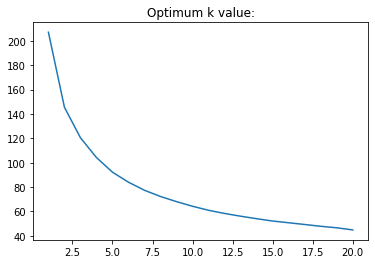

In [212]:
model = c.model_base()
H = model(x).numpy()[:, :hidden_units]
c.optimized_kmeans(H)

In [213]:
k = 5
y_pred = c.train(H, k)

Initialization complete
Iteration 0, inertia 124.69149780273438
Iteration 1, inertia 98.55249786376953
Iteration 2, inertia 95.87770080566406
Iteration 3, inertia 95.27529907226562
Iteration 4, inertia 95.05078887939453
Iteration 5, inertia 94.92021179199219
Iteration 6, inertia 94.81523132324219
Iteration 7, inertia 94.72984313964844
Iteration 8, inertia 94.67378997802734
Iteration 9, inertia 94.62430572509766
Iteration 10, inertia 94.59684753417969
Iteration 11, inertia 94.57561492919922
Iteration 12, inertia 94.5560302734375
Iteration 13, inertia 94.54299926757812
Iteration 14, inertia 94.52725982666016
Iteration 15, inertia 94.50678253173828
Iteration 16, inertia 94.49549865722656
Iteration 17, inertia 94.48410034179688
Iteration 18, inertia 94.47542572021484
Iteration 19, inertia 94.47042846679688
Iteration 20, inertia 94.46585083007812
Iteration 21, inertia 94.45841217041016
Iteration 22, inertia 94.43802642822266
Iteration 23, inertia 94.429931640625
Iteration 24, inertia 94.427

Iteration 28, inertia 92.47634887695312
Iteration 29, inertia 92.41847229003906
Iteration 30, inertia 92.3770751953125
Iteration 31, inertia 92.29314422607422
Iteration 32, inertia 92.2506332397461
Iteration 33, inertia 92.22509765625
Iteration 34, inertia 92.2202377319336
Iteration 35, inertia 92.21953582763672
Iteration 36, inertia 92.21884155273438
Iteration 37, inertia 92.2186050415039
Converged at iteration 37: strict convergence.
Initialization complete
Iteration 0, inertia 139.67547607421875
Iteration 1, inertia 111.47124481201172
Iteration 2, inertia 105.61317443847656
Iteration 3, inertia 102.82186126708984
Iteration 4, inertia 99.77330780029297
Iteration 5, inertia 97.19817352294922
Iteration 6, inertia 95.16615295410156
Iteration 7, inertia 94.28398132324219
Iteration 8, inertia 93.73634338378906
Iteration 9, inertia 93.3664321899414
Iteration 10, inertia 93.13227844238281
Iteration 11, inertia 92.99736785888672
Iteration 12, inertia 92.9140396118164
Iteration 13, inertia 92

In [214]:
y_pred

array([2, 0, 3, ..., 4, 1, 4])

In [215]:
class TopicModelling:
    def __init__(self,ds_name):
        self.ds_name = ds_name
        import os
        try:
            os.mkdir('TopicModels')
            os.mkdir('TopicModels/20NEWS')
            os.mkdir('TopicModels/BBC')
            os.mkdir('TopicModels/Kpris')
            print("Directory Generated")
        except FileExistsError:
            print("Directory already exists")
            
    def get_text(self):
        if self.ds_name == "20NEWS":
            from sklearn.datasets import fetch_20newsgroups
            _20news = fetch_20newsgroups(subset="all")
            data = _20news.data
        elif self.ds_name == "BBC":
            import pandas as pd
            df = pd.read_csv("bbc-news-data.csv",sep='\t')
            data = df["title"] + " " + df["content"]
        elif self.ds_name =="Kpris":
            import pandas as pd
            df = pd.read_csv("kpris_data.csv")
            data = df.abstract.str[:-3]
        return data
    
    def sort_data_to_clusters(self,data,clusters):
        cluster_data={}
        for cluster_num in range(0,len(clusters)):
            if clusters[cluster_num] not in cluster_data:
                cluster_data[clusters[cluster_num]]=[]
            cluster_data[clusters[cluster_num]].append(data[cluster_num])
        return cluster_data
    
    def topic_models(self,cluster_data,depth=3,rm_top=200,iterations=10):
        topicModels={}
        for cluster in cluster_data:
            topicModel = tp.HLDAModel(depth=depth,rm_top=rm_top)
            for doc in cluster_data[cluster]:
                if len(doc)>0:
                    if self.ds_name=="Kpris":
                        topicModel.add_doc([str(x) for x in nlp(doc)])
                    else:
                        topicModel.add_doc([str(x) for x in nlp(doc).ents])
            for counter in range(0, 100, iterations):
                topicModel.train(iterations)
            topicModels[cluster]=topicModel
        return topicModels
    
    def save_models(self,topic_models):
        if self.ds_name == "20NEWS":
            for model_cluster in topic_models:
                topic_models[model_cluster].save(f'TopicModels/20NEWS/20NEWS_HLDA_Topic_Model_cluser_{model_cluster}.bin')
        if self.ds_name == "BBC":
            for model_cluster in topic_models:
                topic_models[model_cluster].save(f'TopicModels/BBC/BBC_HLDA_Topic_Model_cluser_{model_cluster}.bin')
        if self.ds_name == "Kpris":
            for model_cluster in topic_models:
                topic_models[model_cluster].save(f'TopicModels/Kpris/Kpris_HLDA_Topic_Model_cluser_{model_cluster}.bin')
    
    def load_models(self,clusters):
        topicModels={}
        if self.ds_name == "20NEWS":
            for i in range(0,clusters):
                topicModels[i]=tp.HLDAModel.load(f'TopicModels/20NEWS/20NEWS_HLDA_Topic_Model_cluser_{i}.bin')
        if self.ds_name == "BBC":
            for i in range(0,clusters):
                topicModels[i]=tp.HLDAModel.load(f'TopicModels/BBC/BBC_HLDA_Topic_Model_cluser_{i}.bin')
        if self.ds_name == "Kpris":
            for i in range(0,clusters):
                topicModels[i]=tp.HLDAModel.load(f'TopicModels/Kpris/Kpris_HLDA_Topic_Model_cluser_{i}.bin')
            return topicModels
    
    def process_models(self,topic_models):
        stop_words = set(stopwords.words('english'))
        
        processed_topics={}
        for i in topic_models:
            processed_topics[i]=[]
            for k,l in topic_models[i].get_topic_words(0):
                if k:
                    processed_topics[i].append(k)
            for j in topic_models[i].children_topics(0):
                for k,l in topic_models[i].get_topic_words(j):
                    if k:
                        processed_topics[i].append(k)
        for i in processed_topics:
            processed_topics[i] = " ".join(processed_topics[i]).lower() #Lower-Casing
            processed_topics[i] = " ".join(s for s in processed_topics[i].split() if not any(c.isdigit() for c in s))
            processed_topics[i] = word_tokenize(processed_topics[i])
            processed_topics[i] = [w for w in processed_topics[i] if not w in stop_words]
            processed_topics[i] = [lemmatizer.lemmatize(word) for word in processed_topics[i]]
            processed_topics[i] = " ".join(processed_topics[i])
            processed_topics[i] = "".join(e for e in processed_topics[i] if e.isalnum() or e.isspace())
            processed_topics[i] = nlp(processed_topics[i]).ents
        return processed_topics

In [15]:
text=Kpris.get_text()

In [16]:
cluster_data = Kpris.sort_data_to_clusters(text,y_pred)

In [17]:
tM = Kpris.topic_models(cluster_data,3,500)

In [29]:
for i in tM:
    tM[i].summary()

<Basic Info>
| HLDAModel (current version: 0.12.2)
| 9465 docs, 225594 words
| Total Vocabs: 16576, Used Vocabs: 16076
| Entropy of words: 8.50713
| Entropy of term-weighted words: 8.50713
| Removed Vocabs: the a of , . and to The is in for memory an A - first data camera includes graphics system with on device that are second by from one car or at be image which unit method plurality ) may processing ( each control as least having provided can circuit has between portion In display processor signal video information CPU   ; controller configured apparatus An lens more computer frame module into operation based power side position including layer such end two body coupled include surface connected light invention set comprises cell through storage line using address images when assembly time object within voltage access vehicle output structure present user member used sensor array interface corresponding also input associated region disclosed buffer direction mounted other receiving s

|     #237 (119, 13) : holder held hand tripod rod
|     #305 (85, 7) : vibrator female coupling male wedge
|     #332 (142, 15) : lane thermal secondary sink stationary
|     #591 (66, 3) : intersecting shock gas racks linkages
|     #836 (66, 6) : roof pillar reinforcement antenna lamp
|     #848 (93, 7) : pressure backing simulating placed shirt
|   #81 (335, 56) : radio navigation RF picture analog
|     #76 (288, 24) : transmitter receiver transmitting activation portable
|     #77 (193, 14) : equipment reception road service fragrance
|     #345 (232, 13) : map navigation destination route update
|     #721 (35, 1) : Schnabel spreader arm comprise sections
|     #929 (52, 4) : AV file Host situations play
|   #82 (555, 109) : cable guide counterweight roller hole
|     #78 (172, 10) : tension strut longitudinal sling vibrations
|     #117 (294, 22) : sheave hoistway locking radio landing
|     #126 (112, 6) : pulley manifold belt suspending pulleys
|     #158 (209, 19) : guide M.

|   #844 (168, 23) : feature sampled 2D adaptively tracking
|     #764 (186, 23) : reset counter cycle status prescribed
|   #845 (108, 15) : bay quantum addressable focal skipped
|     #371 (270, 15) : water wash tube valve oil
|   #846 (80, 6) : token interval hypervisor trusted stall
|     #816 (21, 6) : manual transceiver tables trainable showing
|   #847 (85, 8) : mountable interfaces techniques wires enclosure
|     #542 (62, 3) : stem joint 13 collar ball
|     #934 (30, 5) : focusing spacing defocus markings magnitude
|   #864 (135, 12) : doors cutting creeper panels guided
|     #863 (70, 12) : impact calibrated deforming returning break
|   #865 (112, 9) : password graph assessment term long
|     #809 (28, 9) : entered pen characters producing editing
|   #866 (95, 9) : separating medium covered helper particulate
|     #758 (94, 9) : clear symbol plot forms merchandiser
|   #867 (98, 8) : hub NVM EN fan step
|     #851 (62, 8) : Sibling thermal boards cards chipset
|   #868

|     #435 (25, 3) : files station prompted authorization facilitates
|     #591 (68, 5) : rearmost concave projection plane closest
|   #495 (76, 11) : grinding seal stones discharge vacuum
|     #225 (102, 9) : parts appearance tool exterior diagnostic
|     #393 (62, 2) : materials total 765 provisional maximum
|   #528 (78, 5) : hidden would visible parent fuzzy
|     #394 (21, 2) : clicking # electronically linkage seats
|     #551 (37, 3) : charged pinhole inch printed 1/3
|   #529 (44, 3) : resistant alloy self Subsequent adaptive
|     #521 (65, 3) : % fibers polyester areas stress
|   #530 (34, 4) : asphalt residual interior tag brittle
|     #482 (35, 4) : resistive tone transistors terminals select
|   #531 (96, 15) : identification WID configuring super train
|     #101 (4, 2) : thereon metastability Corresponding conveyed condition
|     #188 (93, 6) : regulator attribute SSD PVID selection
|     #550 (100, 7) : cord ray axial lenslet steel
|   #532 (58, 8) : controls pref

|     #619 (82, 7) : onto reflected scanner document feature
|   #405 (99, 9) : casing yaw built affected t
|     #131 (0, 1) : coil bits move under members
|     #666 (47, 8) : disk pitching accommodating escape rotatable
|   #406 (96, 20) : clutch brightness mask pedal valid
|     #439 (96, 12) : emission automatic insertion manual gearbox
|     #453 (30, 1) : " exposed course standard caption
|     #506 (69, 7) : 6 modules K 19 7
|   #407 (56, 12) : ports identification characters port auxiliary
|     #440 (123, 11) : covered shell coating made plastic
|     #574 (0, 1) : coil bits move under members
|   #456 (103, 22) : sheet glass posture estimating near
|     #148 (76, 11) : harness occupant activating deceleration working
|     #511 (63, 7) : rest magnetoresistance coil heater fabric
|     #540 (59, 4) : marks compensation dial work automatic
|   #457 (59, 9) : cooling skyrmion duct blow keep
|     #287 (57, 2) : coordinates vertices attribute vertex homogeneous
|     #352 (3, 1

|     #188 (151, 22) : testing cases tested microprocessor results
|   #192 (299, 43) : floating bits M N configurable
|     #189 (148, 14) : M latches conductor insulated therefrom
|     #218 (155, 11) : per bits arrays writing loop
|     #539 (74, 4) : N associative LSTM chips MAT
|     #552 (46, 6) : cryptographic stable pending unstable decrypts
|     #649 (26, 4) : logarithm graphing accelerator D.sup log.sub.2
|     #698 (59, 4) : room home living service converted
|   #193 (191, 30) : resistor compression termination compressed padding
|     #190 (98, 6) : garbage collection written objects tasks
|     #314 (106, 13) : resistive driven across drop shared
|     #407 (80, 11) : windowpane molding transparent strip reflected
|   #194 (150, 38) : file subject entry among metadata
|     #200 (53, 9) : standard accessing applications characteristics console
|     #207 (110, 9) : routine interrupt repair samples TSVs
|     #509 (138, 14) : backup accessory specific static saving
|     

BBC Model Generation

In [216]:
ds_name = 'BBC'
loader = LoadData(ds_name)
x = loader.get_embeddings()
epochs, pretrain_batch_size, batch_size, input_shape, hidden_units = 100, 256, 256, 768, 100
c = Cluster(ds_name, epochs, pretrain_batch_size, batch_size, input_shape, hidden_units)
ds_xx = tf.data.Dataset.from_tensor_slices((x, x)).batch(pretrain_batch_size)
c.train_base(ds_xx)
model = c.model_base()
H = model(x).numpy()[:, :hidden_units]
c.optimized_kmeans(H)
k = 5
y_pred = c.train(H, k)
BBC = TopicModelling("BBC")
text = BBC.get_text()
cluster_data = BBC.sort_data_to_clusters(text,y_pred)
tM = BBC.topic_models(cluster_data)
BBC.save_models(tM)
processed_topics = BBC.process_models(tM)

Directory already exists


20NEWS

Dataset 20NEWS loaded...
model_conv: weights was loaded
Epoch 1/100
74/74 - 3s - loss: 8.9813e-04 - 3s/epoch - 41ms/step
Epoch 2/100
74/74 - 3s - loss: 8.2678e-04 - 3s/epoch - 35ms/step
Epoch 3/100
74/74 - 3s - loss: 7.8470e-04 - 3s/epoch - 38ms/step
Epoch 4/100
74/74 - 3s - loss: 7.5191e-04 - 3s/epoch - 36ms/step
Epoch 5/100
74/74 - 3s - loss: 7.4724e-04 - 3s/epoch - 40ms/step
Epoch 6/100
74/74 - 3s - loss: 7.4271e-04 - 3s/epoch - 40ms/step
Epoch 7/100
74/74 - 3s - loss: 7.3866e-04 - 3s/epoch - 39ms/step
Epoch 8/100
74/74 - 3s - loss: 7.3380e-04 - 3s/epoch - 43ms/step
Epoch 9/100
74/74 - 3s - loss: 7.2755e-04 - 3s/epoch - 41ms/step
Epoch 10/100
74/74 - 3s - loss: 7.2574e-04 - 3s/epoch - 43ms/step
Epoch 11/100
74/74 - 4s - loss: 7.2067e-04 - 4s/epoch - 51ms/step
Epoch 12/100
74/74 - 3s - loss: 7.1828e-04 - 3s/epoch - 43ms/step
Epoch 13/100
74/74 - 3s - loss: 7.1702e-04 - 3s/epoch - 42ms/step
Epoch 14/100
74/74 - 3s - loss: 7.1653e-04 - 3s/epoch - 41ms/step
Epoch 15/100
74/74 - 3s - los

Initialization complete
Iteration 0, inertia 2936.0810546875
Iteration 1, inertia 1777.53271484375
Iteration 2, inertia 1732.9317626953125
Iteration 3, inertia 1721.9334716796875
Iteration 4, inertia 1715.0357666015625
Iteration 5, inertia 1708.3734130859375
Iteration 6, inertia 1698.67138671875
Iteration 7, inertia 1684.419677734375
Iteration 8, inertia 1666.388671875
Iteration 9, inertia 1652.050537109375
Iteration 10, inertia 1645.2196044921875
Iteration 11, inertia 1641.9368896484375
Iteration 12, inertia 1640.271484375
Iteration 13, inertia 1639.465576171875
Iteration 14, inertia 1638.9677734375
Iteration 15, inertia 1638.7490234375
Iteration 16, inertia 1638.601318359375
Iteration 17, inertia 1638.4757080078125
Iteration 18, inertia 1638.3695068359375
Iteration 19, inertia 1638.280029296875
Iteration 20, inertia 1638.2281494140625
Iteration 21, inertia 1638.19677734375
Iteration 22, inertia 1638.181396484375
Iteration 23, inertia 1638.17138671875
Iteration 24, inertia 1638.169921

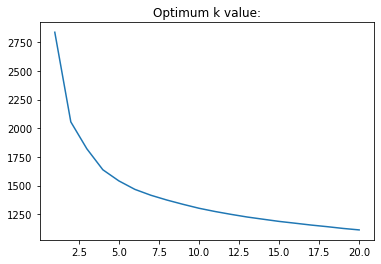

In [225]:
ds_name = '20NEWS'
loader = LoadData(ds_name)
x = loader.get_embeddings()
epochs, pretrain_batch_size, batch_size, input_shape, hidden_units = 100, 256, 256, 768, 100
c = Cluster(ds_name, epochs, pretrain_batch_size, batch_size, input_shape, hidden_units)
ds_xx = tf.data.Dataset.from_tensor_slices((x, x)).batch(pretrain_batch_size)
c.train_base(ds_xx)
model = c.model_base()
H = model(x).numpy()[:, :hidden_units]
c.optimized_kmeans(H)
k = 4
y_pred = c.train(H, k)
_20news = TopicModelling(ds_name)
text = _20news.get_text()
cluster_data = _20news.sort_data_to_clusters(text,y_pred)
tM = _20news.topic_models(cluster_data)
_20news.save_models(tM)
processed_topics = _20news.process_models(tM)

In [228]:
processed_topics[1]

(tonight,
 six,
 one,
 last minute,
 stl nym,
 hb h   ,
 arthur stewart roger,
 edwin barkdoll,
 tom stockfisch,
 steve pruitt,
 canseco boggs,
 mike,
 jonathan king reichsfuehrerss,
 karina fifth seryozha azerbaijani   gh,
 mn l ec,
 third,
 arsene guiana,
 thursday,
 japan,
 toru miller,
 stephen graham,
 irs,
 jay,
 brinkmeyer chris,
 andrei,
 alberta edmonton canada,
 mac,
 macintosh dce,
 gordon lang xsun,
 dik university amsterdam line casper,
 nixon,
 soviet,
 zero,
 soviet,
 carsonuwashingtonedu erickson s,
 larry margolis,
 kaul boca raton,
 ibm,
 sony,
 fda,
 kale,
 barbara hlavin motorola inc kidney stone,
 washington,
 silva walter f lundby,
 mary shafer,
 six,
 marc anderson navy,
 nasa,
 gaza,
 dudu danny idf,
 saudi arabia,
 john jeruselem,
 mary magdalene,
 cornell national,
 hispanic,
 jordan mcauley,
 consumer week,
 kevin l mcbride gestapo least,
 john white gordon,
 zero,
 ron roth,
 ron american computer science corp,
 african,
 harry langenbacher,
 ron stafford,
 

Kpris Model Generation

In [ ]:
ds_name = 'Kpris'
loader = LoadData(ds_name)
x = loader.get_embeddings()
epochs, pretrain_batch_size, batch_size, input_shape, hidden_units = 100, 256, 256, 768, 100
c = Cluster(ds_name, epochs, pretrain_batch_size, batch_size, input_shape, hidden_units)
ds_xx = tf.data.Dataset.from_tensor_slices((x, x)).batch(pretrain_batch_size)
c.train_base(ds_xx)
model = c.model_base()
H = model(x).numpy()[:, :hidden_units]
c.optimized_kmeans(H)
k = 4
y_pred = c.train(H, k)
kpris = TopicModelling(ds_name)
text = kpris.get_text()
cluster_data = kpris.sort_data_to_clusters(text,y_pred)
tM = kpris.topic_models(cluster_data)
kpris.save_models(tM)
processed_topics = kpris.process_models(tM)